In [3]:
import numpy as np
import os
import math
import torch
import torch.nn as nn
import torchnet as tnt
from torchnet.engine import Engine
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import models


from torch.utils.data import Dataset, DataLoader
import h5py
from torchvision import transforms

import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm_notebook as tqdm
from torchsummary import summary

print(torch.__version__)
device = torch.device('cuda:1')

1.2.0


In [39]:
class Weedread(Dataset):
    def __init__(self, name, transform=None):
        hf = h5py.File(name, 'r')
        self.input_images = np.array(hf.get('data'), np.uint8)
        self.target_labels = np.array(hf.get('labels')).astype(np.long)
        self.transform = transform
        hf.close()

    def __len__(self):
        return self.input_images.shape[0]

    def __getitem__(self, idx):
        images = self.input_images[idx]
        classes = self.target_labels[idx][1]
        family =  self.target_labels[idx][0]
        if self.transform is not None:
            images = self.transform(images)
        images = images
        
        return images, classes

class calTech(Dataset):
    def __init__(self, name, transform=None):
        hf = h5py.File(name, 'r')
        self.input_images = np.array(hf.get('features'))
        self.input_labels = np.array(hf.get('labels')).astype(np.long)
        self.transform = transform
        hf.close()

    def __len__(self):
        return (self.input_images.shape[0])

    def __getitem__(self, idx):
        images = self.input_images[idx]
        labels = self.input_labels[idx]
        if self.transform is not None:
            images = self.transform(images)
        return images, labels

In [40]:
INPUT_CHANNEL = 3
BATCH_SIZE = 10
normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

classes = [str(i) for i in range(102)]

data_path = os.path.dirname(os.getcwd()) + "/data/calTech/"
calTech_data = calTech(data_path + "train.h5", transform=normalize)
calTech_dataloader = DataLoader(dataset=calTech_data, batch_size = BATCH_SIZE, shuffle=True)

In [41]:
INPUT_CHANNEL = 3
BATCH_SIZE = 10
normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

imagenet_classes = range(1, 22)

data_path = os.path.dirname(os.getcwd()) + "/data/weed/"
#Train_data = Weedread(data_path + "train.h5", transform=normalize)
Weed_data = Weedread(data_path + "val.h5", transform=normalize)

Weed_dataloader = DataLoader(dataset=Weed_data, batch_size = BATCH_SIZE, shuffle=True)

In [42]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

class ResNet_baseline(nn.Module):
    def __init__(self, num_classes = 21):
        super(ResNet_baseline, self).__init__()
        model = models.resnet18(pretrained=False)
        self.model_ft = torch.nn.Sequential(*(list(model.children())[:-1]))
        set_parameter_requires_grad(self.model_ft, False)

        self.class_fc = nn.Linear(512, num_classes)
        
    
    def forward(self, x):
        # Perform the usual forward pass
        x = self.model_ft(x)
        x = torch.flatten(x, 1)
        x_class = self.class_fc(x)
       
        return x_class

In [43]:
def get_feature(image, model):
    _model.eval()
    with torch.no_grad():
        image = image.to(device)
        image = image.float()
            
        feature = _model.model_ft(image)
        feature = torch.flatten(feature, 1)
    return feature.cpu().numpy()

In [44]:
_model = ResNet_baseline()


test_images, _ = next(iter(Weed_dataloader))
summary(_model, input_size= test_images[0].size(), device="cpu")

_model = _model.to(device)
_model.load_state_dict(torch.load('epochs/ResNet-labelsmoothing.pt'), strict=False)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

<All keys matched successfully>

In [45]:
hf = h5py.File('epochs/feature_maps.h5', 'r')
feature_maps = np.array(hf.get('features'))
labels = np.array(hf.get('labels'))
hf.close()
print(feature_maps.shape)

(125498, 512)


In [46]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
clf = QuadraticDiscriminantAnalysis(store_covariance=True)
clf.fit(feature_maps, labels)
tied_cov = np.sum(clf.covariance_, axis=0)
means = clf.means_

/home/dspserver/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [47]:
def M(x, tied_cov, means):
    confidence_score = 1000*np.ones(x.shape[0])
    inv = np.linalg.inv(tied_cov)
    for i in range(0, means.shape[0]):
        t = x - means[i]
        score = np.dot(np.dot(t, inv), t.T)
        score = np.diag(score)
        for j in range(0, x.shape[0]):
            if(score[j] < confidence_score[j]):
                confidence_score[j] = score[j]
    return (confidence_score)

hf = h5py.File('epochs/feature_maps_Cal.h5', 'r')
cal_feature_maps = np.array(hf.get('features'))
cal_labels = np.array(hf.get('labels'))
hf.close()
print(cal_feature_maps.shape)

In [82]:
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
inv_normalize = transforms.Normalize([-0.485/0.229, -0.456/0.224, -0.406/0.225], [1/0.229, 1/0.224, 1/0.225])

def tensor_to_img(t):
    """Convert normalized tensor in Cuda to cv2 image"""
    unnormalized = inv_normalize(t)
    npimg = np.transpose(unnormalized.cpu().numpy(), (1, 2, 0))
    return npimg

def imshow_multi(list_img, predicted = None, score = None, label = None, n_cols = 5):
    list_img = [tensor_to_img(image) for image in list_img]
    n_rows = math.ceil((len(list_img))/n_cols)
    fig, axes = plt.subplots(n_rows,n_cols, figsize=(4*n_cols,4*n_rows))
    for i,ax in enumerate(axes.flat):
        ax.grid(False)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if i>=len(list_img):
            continue
        if(predicted is not None):
            text = "class %d, true class %d, score %d"%(predicted[i], label[i], score[i])
            ax.set_title(text)

        ax.imshow(list_img[i])
        
    plt.tight_layout()

In [83]:
def two_steps_predict(data, label, confidence_the):
    feature = get_feature(data, _model)
    confidence_score = M(feature, tied_cov, means)
    
    predicted = clf.predict(feature)
    for i in range(0, predicted.shape[0]):
        if(confidence_score[i] > confidence_the):
            predicted[i] = - 1
    return predicted, confidence_score

In [88]:
calTech_batch, calTech_cls = next(iter(calTech_dataloader))
Weed_batch, Weed_cls = next(iter(Weed_dataloader))

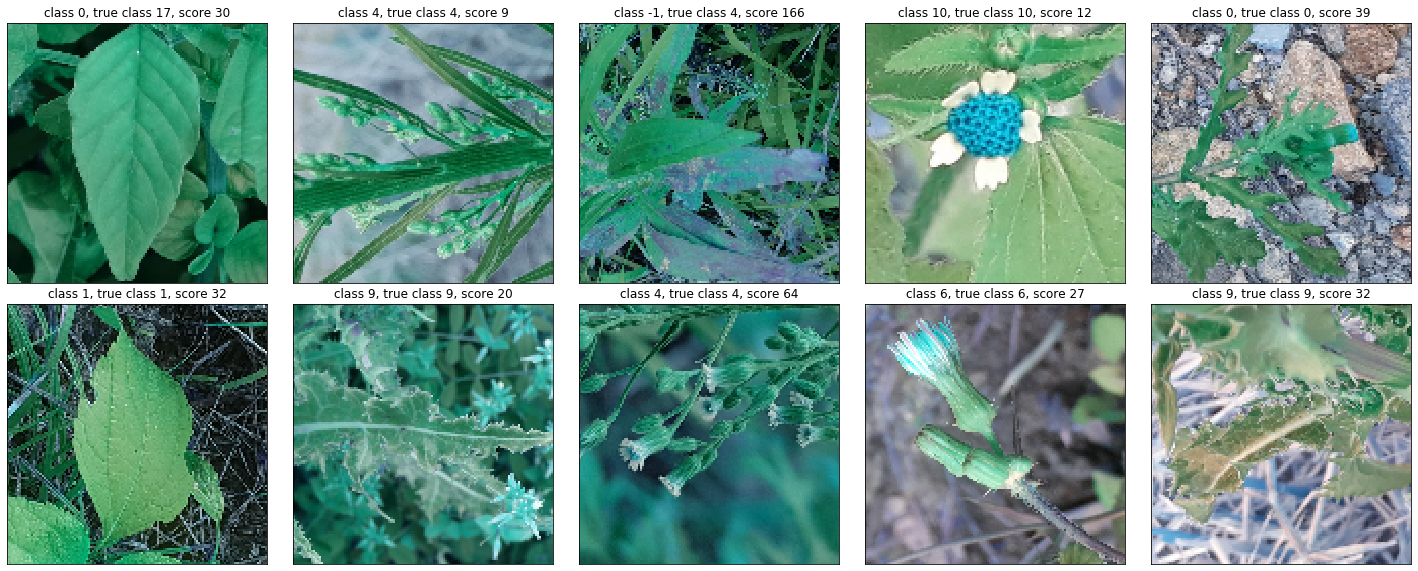

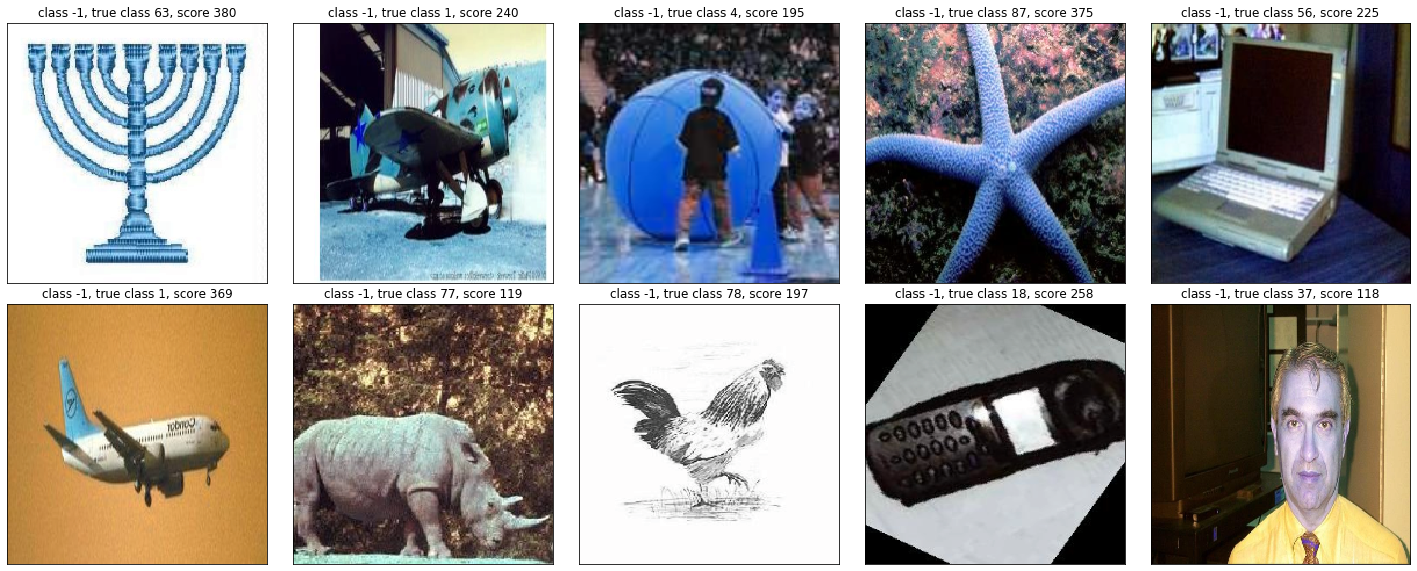

In [89]:
Weed_predicted, Weed_confidence_score  = two_steps_predict(Weed_batch, Weed_cls, confidence_the = 105)
calTech_predicted, calTech_confidence_score = two_steps_predict(calTech_batch, calTech_cls, confidence_the = 105)

imshow_multi(Weed_batch, predicted = Weed_predicted, score = Weed_confidence_score, label = Weed_cls)
imshow_multi(calTech_batch, predicted = calTech_predicted, score = calTech_confidence_score, label = calTech_cls)